This code just sets a Threshold level to reduce the dimensionality of the 2D data to a set of scalars. This is becuase fitting gaussians to extract the distribution width is not
well posed.

In [1]:
# This also uses the 'radial functions' python codeS
# /Volumes/LAB_AKALANKA/GitHub/FSVPy/SyntheticStreaks/radial_functions.py

In [2]:
particle_size = 3 #um, real diameter of particle

In [3]:
import sys
#sys.path.append('/Volumes/LAB_AKALANKA/GitHub/FSVPy/SyntheticStreaks')

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pims
import numpy as np
import pandas as pd
import radial_functions as fun

In [5]:
mpl.rc('figure', figsize=(10,5))
mpl.rc('image', cmap='gray')
#matplotlib specs

@pims.pipeline
def conv_gray(frame):
    one_channel = frame[:,:,1]
    return one_channel

frames =(pims.open('D:/Lab_Data_Akalanka/2024_06_29/cropped2/*.tif'))
#frames2 =(pims.open('/Volumes/LAB_AKALANKA/Aug24/2024_07_12/cropped/top/*.tif'))
#frames3 =(pims.open('/Volumes/LAB_AKALANKA/Aug24/2024_07_12/cropped/mid/*.tif'))
#img = frames[:107]
img = frames[:]
#fun.see_contour(img[95],True)

In [6]:
## Some helper functions

def Get_Center(img,frameStart, frameEnd, plott):

    img = img[frameStart:frameEnd]
    contour = fun.see_all_contours(img,100)
    xpos = np.asarray(contour['x'])
    ypos = np.asarray(contour['y'])
    radius = np.asarray(contour['radius'])[:]

    #Plot to see the image
    #call to plot_frame
    if plott==True:
        plot_frame(frames[frameStart],xpos,ypos,radius)

    return (xpos, ypos)

#plot contour inside frame
def plot_frame(frame,xpos,ypos,radius):
        
    fig, ax = plt.subplots()
    ax.imshow(frame,  cmap="Greys_r")
    ax.plot(xpos,ypos, 'r+', linewidth='2')
    circle1 = plt.Circle((xpos, ypos),radius,color='r', fill=False, linewidth=0.5)
    ax.add_patch(circle1)

    fig.canvas.draw()
    plt.show()

    return 

In [7]:
radius=[] 
centerx=[]; centery =[]; radial_profiles=[];
for i, frame in enumerate(img):
    x, y = Get_Center(img,i,i+ 1,False)
    r= fun.find_radius(img[i],[x,y])
    centerx.append(x)
    centery.append(y)
    radius.append(r)

...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
.

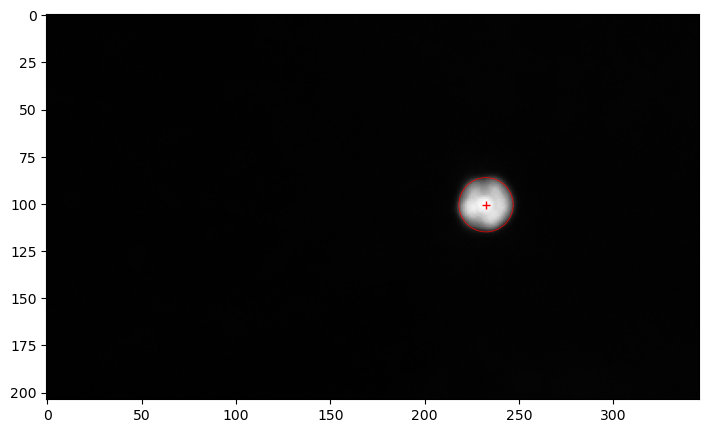

The radius here is:  14.379275855171034


In [15]:
#plot an example frame to see the thresholded radius

frame_to_plot = -60

plot_frame(img[frame_to_plot],centerx[frame_to_plot],centery[frame_to_plot],radius[frame_to_plot])
print('The radius here is: ',radius[frame_to_plot])

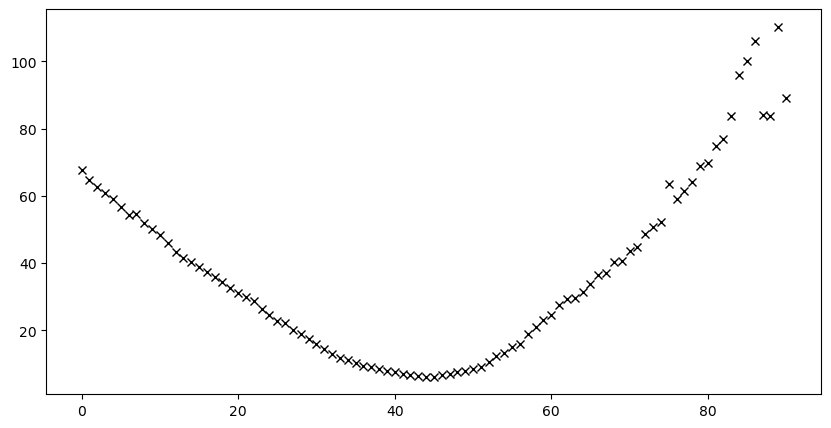

In [9]:
plt.plot(np.arange(len(radius)),radius,'kx')

In [10]:
#user defined parameters

res = 325 #nm per px
RIfix = 1.33
step_size = 0.75 #um

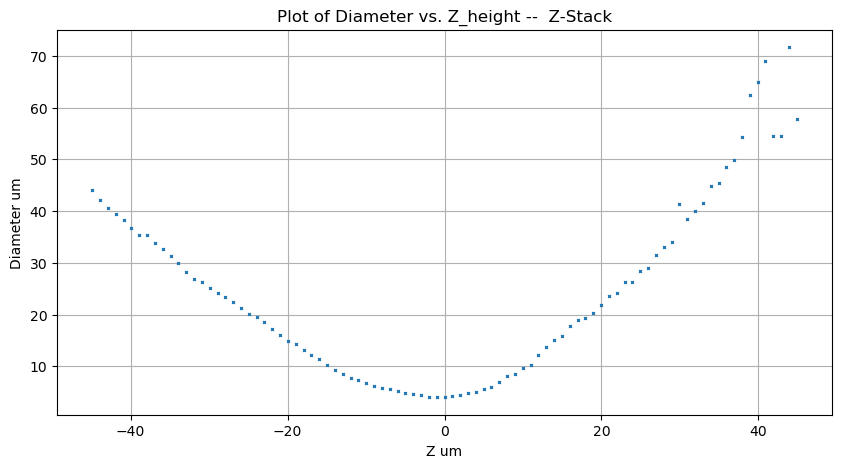

In [11]:

dii = np.asarray(radius) * 2*(res/1000)  #diameter in micron
plotframes = np.arange(len(dii))*step_size*RIfix# 0.25 um is the step size of the z-stack!

shift = -1*plotframes[np.argmin(dii)]


#calculate z height from the calculated attributes
fig, ax = plt.subplots()
plotframes = plotframes + shift   #re-shifting to make lowest diameter zero
ax.plot(plotframes,dii,'x',markersize=2)

#-----From here on its plotting---- 
#ax.plot(frames, l, ls='--',c='r',linewidth=2)
plt.xlabel('Z um')
plt.ylabel('Diameter um')
plt.title('Plot of Diameter vs. Z_height --  Z-Stack')
plt.grid()

Fit type is hyperbolic ( diameter^2 = A + B* z_height^2)
Gradient is (B) 0.3684610067568299
Intercept is (A)  12.872482656727506


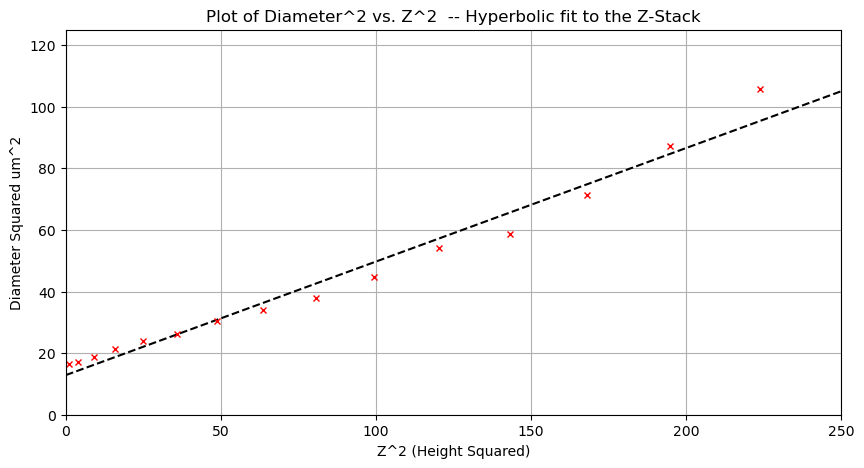

In [28]:
from scipy.optimize import curve_fit
#fit a hyperbolic function to the above diameter vs height variation
plt.figure()
dii_squared = np.multiply(dii,dii)
frame_sqrd = np.multiply(plotframes, plotframes)
pred_params, uncert_cov = curve_fit(fun.line, frame_sqrd[30:np.argmin(dii)], dii_squared[30:np.argmin(dii)], method='lm')
x = np.linspace(-shift,0,100) + shift
yy = (pred_params[1] + pred_params[0]* np.multiply(x,x))
plt.plot(np.multiply(x,x), yy, ls='--',c='k')
plt.plot(frame_sqrd[30:np.argmin(dii)],dii_squared[30:np.argmin(dii)], 'rx',markersize=5)
#plt.plot(frame_sqrd[np.argmin(dii):-1],dii_squared[np.argmin(dii):-1], 'gx',markersize=5)
plt.xlim([0, 250])
plt.ylim([0, 125])

plt.grid()
plt.xlabel('Z^2 (Height Squared)')
plt.ylabel('Diameter Squared um^2')
plt.title('Plot of Diameter^2 vs. Z^2  -- Hyperbolic fit to the Z-Stack')
#plt.legend(['Linearized Hyperbolic fit (Replace objective with simple convex)','Red -Z', 'Green +Z'])
print('Fit type is hyperbolic ( diameter^2 = A + B* z_height^2)')
print('Gradient is (B)', pred_params[0])
print('Intercept is (A) ', pred_params[1])

In [12]:
sys.exit()#terminate here for now...

SystemExit: 

c:\Users\Akalanka\anaconda3\envs\fsvpy\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
#save data
import csv

with open("radius_mid.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(dii)

In [ ]:
#read data from csv file
diameter_bottom=[]
diameter_top=[]
diameter_mid=[]
with open("radius_low.csv", mode='r', newline='') as file:
    reader = csv.reader(file)
    for row in reader:
        diameter_bottom.append(row)

with open("radius_top.csv", mode='r', newline='') as file:
    reader = csv.reader(file)
    for row in reader:
        diameter_top.append(row)

with open("radius_mid.csv", mode='r', newline='') as file:
    reader = csv.reader(file)
    for row in reader:
        diameter_mid.append(row)

diameter_bottom = [float(x)/particle_size for x in diameter_bottom[0]]
diameter_top = [float(x)/particle_size for x in diameter_top[0]]
diameter_mid = [float(x)/particle_size for x in diameter_mid[0]]



FileNotFoundError: [Errno 2] No such file or directory: 'radius_low.csv'

: 

In [ ]:

# Create a new figure
plt.figure()
x1 = np.arange(len(np.asarray(diameter_bottom)))*step_size*RIfix/particle_size 
x2 = np.arange(len(np.asarray(diameter_top)))*step_size*RIfix/particle_size 
x3 = np.arange(len(np.asarray(diameter_mid)))*step_size*RIfix/ particle_size 

# correct for zero in x axis
x1 -= 1*x1[np.argmin(diameter_bottom)]
x2 -= x2[np.argmin(diameter_top)]
x3 -= 1*x3[np.argmin(diameter_mid)]

# Plot the first variable with custom line style and marker
mark =3
alpha = 0.7
plt.plot(x1, diameter_bottom, label=' Bottom', color='blue',linestyle='' ,marker='o',markersize=mark, alpha = alpha)

# Plot the second variable with custom line style and marker
plt.plot(x2, diameter_top,label='Top', linestyle='',color='red',  marker='x',markersize=mark, alpha = alpha)

plt.plot(x3, diameter_mid,label='Middle', linestyle='',color='black',  marker='d',markersize=mark, alpha = alpha)

# Add labels and title
plt.xlabel('Depth/Diameter (Dimensionless)')
plt.ylabel('Width/Diameter (Dimensionless)')
plt.title('Intensity distribution at out of focal planes')

# Add a legend
plt.legend()

# Add grid
plt.grid(True)

# Display the plot
plt.show()